# Paper Plots

This notebook contains the code for making the plots in the offline analysis paper, EXO-23-002.

In [3]:
import os, sys, glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import mplhep as hep
import math
import warnings
import scipy
from plot_utils import *
import uproot
from scipy.stats import chi2
from matplotlib import ticker
from hist import Hist
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerLine2D

warnings.filterwarnings('ignore')
hep.style.use("CMS")
matplotlib.rcParams.update({'figure.max_open_warning': 0})
matplotlib.rcParams['figure.facecolor'] = 'white'

In [4]:
## parameters
outPaperDir = '/home/submit/{}/SUEP/EXO-23-002/images/'.format(os.environ['USER'])
saveToPaper = False

In [5]:
# generate list of files that you want to read histograms
plotDir = '/data/submit/{}/SUEP/outputs/'.format(os.environ['USER'])

# for data
files_2018 = getHistLists(plotDir, 'unblind', '../filelist/Offline/list_2018_JetHT_A02_offline.txt')
files_2017 = getHistLists(plotDir, 'unblind', '../filelist/Offline/list_2017_JetHT_A02_offline.txt')
files_2016 = getHistLists(plotDir, 'unblind', '../filelist/Offline/list_2016_JetHT_A02_offline.txt')
files = files_2018 + files_2017 + files_2016
plots = loader(files)

# and for signal
files_SUEP_2018 = getHistLists(plotDir, 'approval_2018', '../filelist/Offline/list_full_signal_offline.txt')
files_SUEP_2017 = getHistLists(plotDir, 'approval_2017', '../filelist/Offline/list_full_signal_offline.txt')
files_SUEP_2016 = getHistLists(plotDir, 'approval_2016', '../filelist/Offline/list_full_signal_offline.txt')
files_SUEP_2016apv = getHistLists(plotDir, 'approval_2016apv', '../filelist/Offline/list_full_signal_offline.txt')
files_SUEP = files_SUEP_2018 + files_SUEP_2017 + files_SUEP_2016 + files_SUEP_2016apv
files_SUEP = [f for f in files_SUEP if ('HT1000_T3p00_mS300.000_mPhi3.000_T3.000_modegeneric' in f) or ('HT1000_T3p00_mS1000.000_mPhi3.000_T3.000_modegeneric' in f)]
plots_SUEP_2018 = loader(files_SUEP, year='2018', auto_lumi=False)
plots_SUEP_2017 = loader(files_SUEP, year='2017', auto_lumi=False)
plots_SUEP_2016 = loader(files_SUEP, year='2016', auto_lumi=False)
plots_SUEP_2016apv = loader(files_SUEP, year='2016apv', auto_lumi=False)
for sample in plots_SUEP_2018.keys(): # really wish I could use the new loader() :(
    plots[sample.replace("_2018", "")] = {}
    for plot in plots_SUEP_2018[sample].keys():
        plots[sample.replace("_2018", "")][plot] = plots_SUEP_2018[sample][plot].copy() \
                                    + plots_SUEP_2017[sample.replace("2018", "2017")][plot].copy() \
                                    + plots_SUEP_2016[sample.replace("2018", "2016")][plot].copy() \
                                    + plots_SUEP_2016apv[sample.replace("2018", "2016apv")][plot].copy()

# read in the post-fit histograms
postFitFileName = "/home/submit/lavezzo/SUEP/CMSSW_10_2_13/src/SUEPLimits/allYears_720_v6/cards-GluGluToSUEP_HT1000_T3p00_mS300.000_mPhi3.000_T3.000_modegeneric_TuneCP5_13TeV-pythia8/fitDiagnostics.root" 
postFitFile = uproot.open(postFitFileName)

## ABCD Regions Distribution

In [11]:
def compute_poisson_interval(values, confidence=0.6827):
    alpha = 1 - confidence
    low = chi2.ppf(alpha / 2., 2 * values) / 2
    high = chi2.ppf(1. - alpha / 2., 2 * (values + 1)) / 2
    if hasattr(low, '__len__'): low[np.isnan(low)] = 0
    return low, high

def read_post_fit_file(postFitFile):
   
    expected, expected_err = {}, {}
    for year in ['2016','2017','2018']:
        
        expected[year], expected_err[year] = {}, {}
        
        for fit in ['fit_b', 'prefit']:
                    
            expected[year][fit], expected_err[year][fit] = {}, {}

            for region in ['Bin1Sig','Bin2Sig','Bin3Sig','Bin4Sig',
                            'Bin0crF','Bin1crF','Bin2crF','Bin3crF','Bin4crF',
                            'catcrA', 'catcrB', 'catcrC', 'catcrD', 'catcrE',
                            'catcrG', 'catcrH']:

                name = 'shapes_{}/{}{};1'.format(fit,region,year)
                
                expected[year][fit][region] = postFitFile[name]['expected;1'].values()[0]
                expected_err[year][fit][region] = np.sqrt(postFitFile[name]['total_covar;1'].to_numpy()[0][0][0])

    years = ['2018', '2017', '2016']

    postfits, postfit_errs = [], []
    prefits, prefit_errs = [], []
    for region in ['catcrA', 'catcrB', 'catcrC', 'catcrD', 'catcrE', 
                'Bin0crF','Bin1crF','Bin2crF','Bin3crF','Bin4crF',
                'catcrG', 'catcrH', 'Bin0Sig', 'Bin1Sig','Bin2Sig','Bin3Sig','Bin4Sig']:
        
        # validation region not used for fitting
        if region == 'Bin0Sig':
            postfits.append(np.nan)
            postfit_errs.append(np.nan)
            prefits.append(np.nan)
            prefit_errs.append(np.nan)
            continue
            
        postfit = np.sum([expected[yr]['fit_b'][region] for yr in years]) 
        postfit_err = np.sqrt(np.sum([expected_err[yr]['fit_b'][region]**2 for yr in years]))
        postfits.append(postfit)
        postfit_errs.append(postfit_err)
        
        prefit = np.sum([expected[yr]['prefit'][region] for yr in years]) 
        prefit_err = np.sqrt(np.sum([expected_err[yr]['prefit'][region]**2 for yr in years]))
        prefits.append(prefit)
        prefit_errs.append(prefit_err)
    
    return np.array(postfits), np.array(postfit_errs), np.array(prefits), np.array(prefit_errs)

Read in the postfits and prefits from the limit file

In [16]:
postfits, postfit_errs, _, _ = read_post_fit_file(postFitFile)

Read in the prefit values, which we need because we don't have the Validation Region in the limit cards

In [8]:
plots.keys()

dict_keys(['data', 'data_2018', 'data_2017', 'data_2016', 'mS1000_T3.0_mPhi3.0_generic', 'mS300_T3.0_mPhi3.0_generic'])

In [44]:
plot_label = '2D_SUEP_S1_vs_SUEP_nconst_Cluster70'
xregions = [0.3j, 0.4j, 0.5j, 1.0j]
yregions = [30j, 50j, 70j, 300j]

# data
abcd = plots['data'][plot_label][::,::] 
_, SR_exp = ABCD_9regions_errorProp(abcd, xregions, yregions, sum_var='x')
SR_exp = rebin_piecewise(SR_exp, [70, 90, 110, 130, 170, 200])
prefits = SR_exp.values()
prefit_errs = np.sqrt(SR_exp.variances()) 

# we update the VR postfit as the raw prediction from the data
postfits[np.isnan(postfits)] = prefits[0]
postfit_errs[np.isnan(postfit_errs)] = prefit_errs[0]

Now make the plot

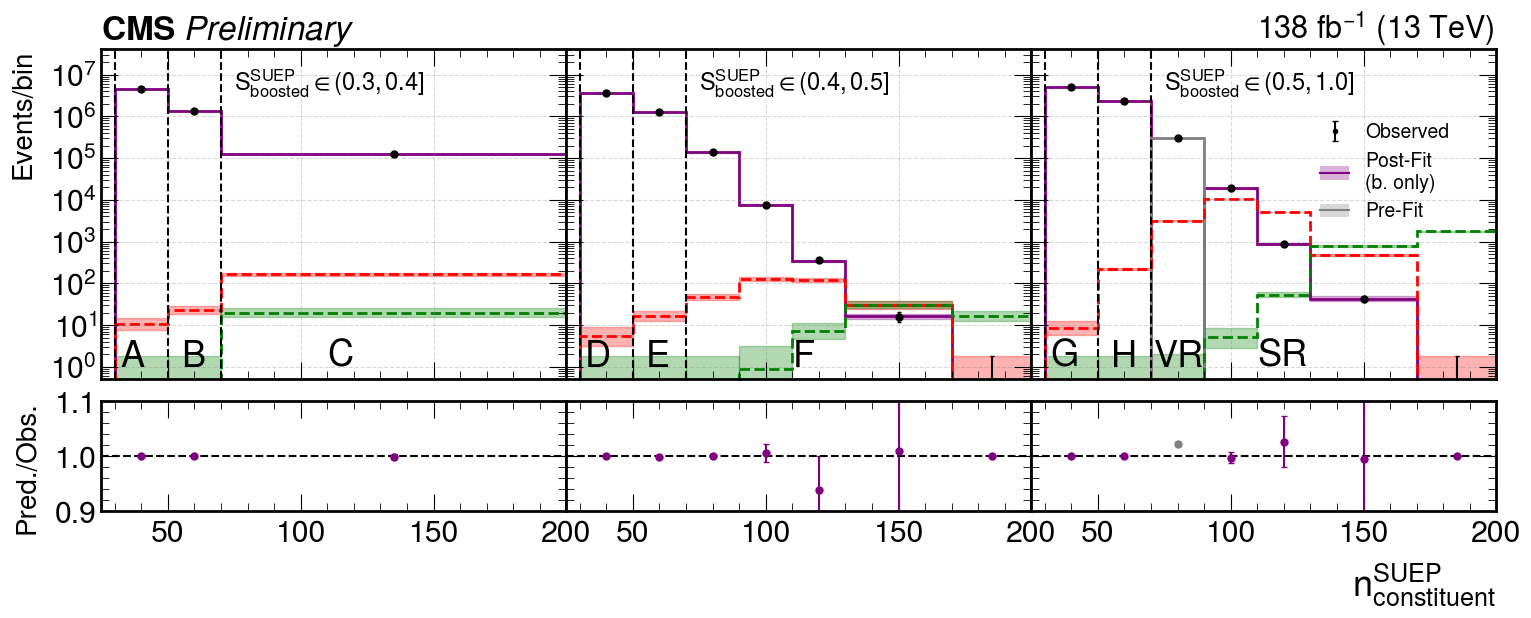

In [53]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 6), sharey=False,sharex=True, 
                         gridspec_kw={'height_ratios': [3,1], 'hspace':0.1, 'wspace':0}) #Plot 3 subplots
fig.subplots_adjust(wspace=0) 
(ax1, ax2, ax3) = axes[0]
(ax1r, ax2r, ax3r) = axes[1]

### PLOTTING PARAMETERS
ymax = 4e6 # Used for the yaxis and some labels
ytop = ymax *10 # The upper limit for the yaxis
regions = {
    'A':(ax1, ax1r, [30,50], 'A', 32, 'purple'),
    'B':(ax1, ax1r, [50,70], 'B', 55, 'purple'),
    'C':(ax1, ax1r, [70,200], 'C', 110, 'purple'),
    'D':(ax2, ax2r, [30,50], 'D', 32, 'purple'),
    'E':(ax2, ax2r, [50,70], 'E', 55, 'purple'),
    'F':(ax2, ax2r, [70, 90, 110, 130, 170, 200], 'F', 110, 'purple'),
    'G':(ax3, ax3r, [30,50], 'G', 32, 'purple'),
    'H':(ax3, ax3r, [50,70], 'H', 55, 'purple'),
    'VR': (ax3, ax3r, [70, 90], 'I', 71, 'gray'),
    'SR': (ax3, ax3r, [90, 110, 130, 170, 200], 'I', 110, 'purple')
}


postfit_index = 0
ax1_postfits, ax1_edges, ax1_s1, ax1_s2 = [], [], [], []
ax2_postfits, ax2_edges, ax2_s1, ax2_s2 = [], [], [], []
ax3_postfits, ax3_edges, ax3_s1, ax3_s2 = [], [], [], []
ax3vr_postfits, ax3vr_edges = [], []
for label, (axis, axis_ratio, edges, letter, label_position, color) in regions.items():

    # region name
    axis.text(label_position, 1, str(label))

    # plot observed data
    h = plots['data'][letter + '_SUEP_nconst_Cluster70'].copy()
    h = rebin_piecewise(h, edges)
    obs, _ = h.to_numpy()
    obs_low, obs_high = compute_poisson_interval(obs)
    obs_yerr = (obs - obs_low, obs_high - obs)
    axis.errorbar(h.axes[0].centers, obs, yerr=obs_yerr, linestyle='',c='black',ms=10,capsize=1.5,fmt ='.')

    # grab signal
    h_s1 = plots['mS300_T3.0_mPhi3.0_generic'][letter + '_SUEP_nconst_Cluster70'].copy()
    h_s1 = rebin_piecewise(h_s1, edges)
    h_s2 = plots['mS1000_T3.0_mPhi3.0_generic'][letter + '_SUEP_nconst_Cluster70'].copy()
    h_s2 = rebin_piecewise(h_s2, edges)
    s1, _ = h_s1.to_numpy()
    s2, _ = h_s2.to_numpy()
    s1_low, s1_high = compute_poisson_interval(s1)
    s2_low, s2_high = compute_poisson_interval(s2)
    s1_yerr = (s1_low, s1_high)
    s2_yerr = (s2_low, s2_high)
    
    # plot post-fit data
    postfit_indices = range(postfit_index, postfit_index + len(edges) - 1)
    for iEdge in range(len(edges)-1):
        axis.fill_between([edges[iEdge], edges[iEdge+1]], postfits[postfit_indices[iEdge]] - postfit_errs[postfit_indices[iEdge]], postfits[postfit_indices[iEdge]] + postfit_errs[postfit_indices[iEdge]], color=color, alpha=0.3)
        axis.fill_between([edges[iEdge], edges[iEdge+1]], s1_yerr[0][iEdge], s1_yerr[1][iEdge], color='red', alpha=0.3)
        axis.fill_between([edges[iEdge], edges[iEdge+1]], s2_yerr[0][iEdge], s2_yerr[1][iEdge], color='green', alpha=0.3)
    # need to plot stairs together for each axis so it looks nicer
    if label == 'VR':
        ax3vr_postfits = postfits[postfit_indices]
        ax3_postfits.extend([-1])
        ax3_s1.extend(s1)
        ax3_s2.extend(s2)
        ax3vr_edges = edges
    else:
        if axis == ax1:
            ax1_postfits.extend(postfits[postfit_indices])
            ax1_edges.extend(edges)
            ax1_s1.extend(s1)
            ax1_s2.extend(s2)
        elif axis == ax2:
            ax2_postfits.extend(postfits[postfit_indices])
            ax2_edges.extend(edges)
            ax2_s1.extend(s1)
            ax2_s2.extend(s2)
        elif axis == ax3:
            ax3_postfits.extend(postfits[postfit_indices])
            ax3_edges.extend(edges)
            ax3_s1.extend(s1)
            ax3_s2.extend(s2)
    
    postfits[postfit_indices]
    postfit_index += len(edges) - 1

    # plot ratio
    this_centers = h.axes[0].centers
    this_postfits = postfits[postfit_indices]
    this_postfit_errs = postfit_errs[postfit_indices]
    this_observed = obs
    this_observed_errs_up = obs_yerr[1]
    this_observed_errs_down = obs_yerr[0]
    this_ratio_err_low = np.where(
        this_observed > 0,
        np.sqrt(
            (this_observed ** -2) * (this_postfit_errs**2)
            + (this_postfits ** 2 * this_observed ** -4) * (this_observed_errs_down**2)
        ),
        0,
    )
    this_ratio_err_high = np.where(
        this_observed > 0,
        np.sqrt(
            (this_observed ** -2) * (this_postfit_errs**2)
            + (this_postfits ** 2 * this_observed ** -4) * (this_observed_errs_up**2)
        ),
        0,
    )
    ratio = np.where(this_observed > 0,
        this_postfits/this_observed,
        1
    )
    axis_ratio.errorbar(this_centers, ratio, yerr=np.array([this_ratio_err_low, this_ratio_err_high]),
                       linestyle='',c=color,ms=10,capsize=2.0,fmt ='.')

# plot the postfit stairs
ax1.stairs(ax1_postfits, sorted(list(set(ax1_edges))), color='purple', lw=2, fill=False)    
ax2.stairs(ax2_postfits, sorted(list(set(ax2_edges))), color='purple', lw=2, fill=False)   
ax3.stairs(ax3_postfits, sorted(list(set(ax3_edges))), color='purple', lw=2, fill=False) 
ax3.stairs(ax3vr_postfits, sorted(list((ax3vr_edges))), color='gray', lw=2, fill=False) 
ax1.stairs(ax1_s1, sorted(list(set(ax1_edges))), color='red', lw=2, linestyle='dashed', fill=False)
ax2.stairs(ax2_s1, sorted(list(set(ax2_edges))), color='red', lw=2, linestyle='dashed', fill=False)
ax3.stairs(ax3_s1, sorted(list(set(ax3_edges))), color='red', lw=2, linestyle='dashed', fill=False)
ax1.stairs(ax1_s2, sorted(list(set(ax1_edges))), color='green', lw=2, linestyle='dashed', fill=False)
ax2.stairs(ax2_s2, sorted(list(set(ax2_edges))), color='green', lw=2, linestyle='dashed', fill=False)
ax3.stairs(ax3_s2, sorted(list(set(ax3_edges))), color='green', lw=2, linestyle='dashed', fill=False)

# Decorate axes, draw lines
ax1r.axhline(1, ls="--", color="black")
ax2r.axhline(1, ls="--", color="black")
ax3r.axhline(1, ls="--", color="black")
for ax in axes[0]:
    ax.set_yscale('log')
    ax.set_ylim(0.5,ytop)
    ax.vlines([30,50,70],0.5,ytop,color='black',linestyle='--') #Take bin edges
    ax.set_xlim(25, 200)
    ax.grid(visible=True, which='major', color='grey', linestyle='--', alpha=0.3)
    y_major = ticker.LogLocator(base = 10.0, numticks = 20)
    ax.yaxis.set_major_locator(y_major)
    y_minor = ticker.LogLocator(base = 10.0, subs = np.arange(1.0, 10.0) * 0.1, numticks = 100)
    ax.yaxis.set_minor_locator(y_minor)
    ax.yaxis.set_minor_formatter(ticker.NullFormatter())
axes[1, 0].get_shared_y_axes().join(axes[1, 0], axes[1, 1], axes[1, 2])
ax1r.set_ylim(0.9, 1.1)
for i in range(2):
    for j in range(3):
        if j > 0:  # Check if the column is not the first column
            axes[i, j].set_yticklabels([])  # Remove y-axis labels

# set labels, other text
ax1.set_ylabel('Events/bin',labelpad=10,fontsize=20)
ax1r.set_ylabel('Pred./Obs.',labelpad=10,fontsize=20)
ax3r.set_xlabel('$n^{SUEP}_{constituent}$', labelpad=10, loc='right')
ax1.text(75,ymax,r"$S^{\mathrm{SUEP}}_{\mathrm{boosted}} \in (0.3,0.4]$",fontsize=17)
ax2.text(75,ymax,r"$S^{\mathrm{SUEP}}_{\mathrm{boosted}} \in (0.4,0.5]$",fontsize=17)
ax3.text(75,ymax,r"$S^{\mathrm{SUEP}}_{\mathrm{boosted}} \in (0.5,1.0]$",fontsize=17)

# legend
line, = plt.plot(range(10), color = 'purple')
patch = mpatches.Patch(facecolor='purple', alpha=0.3, linewidth=0)
line2, = plt.plot(range(10), color = 'gray')
patch2 = mpatches.Patch(facecolor='gray', alpha=0.3, linewidth=0)
line3 = plt.errorbar(1000,0, yerr=10, label='Observed', linestyle='',c='black',capsize=2.0,fmt ='.')
ax3.legend([line3, (patch, line), (patch2, line2)], ["Observed", "Post-Fit\n(b. only)", "Pre-Fit"], handler_map = {line : HandlerLine2D(marker_pad = 0)}, 
           loc=(0.6,0.45), fontsize=14)

# Add CMS statements
cms = ax1.text(
    25, ytop*1.7, u"CMS $\it{Preliminary}$",
    fontsize=24, fontweight='bold',
)
lumi = ax3.text(
    110, ytop*1.7, r"%.0f fb$^{-1}$ ($13$ TeV)" % round(lumiLabel('2016')+lumiLabel('2017')+lumiLabel('2018')),
    fontsize=22,
)

fig.tight_layout()

if saveToPaper: plt.savefig(outPaperDir+"/all_regions.pdf", bbox_inches='tight')

The remaining plots in the paper can be made using the SUEPLimits repo.